# Experiment of Hybrid Ensemble Malware Detection (PHMM + DAE + Stacked Classifier) - 
<em> Reference: https://github.com/delphi20/Malware-Detection-with-ML-DL-/blob/main </em>

### Importing the dataset

In [1]:

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch

# Step 1: Load the data
benign_df = pd.read_csv('benign_samples.csv')   # CSV with benign samples
malware_df = pd.read_csv('malware_samples.csv') # CSV with malware samples

# Step 2: Label the data
benign_df['label'] = 0  # Label all benign samples as 0
malware_df['label'] = 1  # Label all malware samples as 1

### Discretising to create observation sequences

In [2]:
from sklearn.cluster import KMeans

features_malware = malware_df.iloc[:,3:-2]

kmeans = KMeans(n_clusters=5)

df_discretized = features_malware.apply(lambda x: kmeans.fit_predict(x.values.reshape(-1, 1)))

malware_df['Observation_Sequence'] = df_discretized.apply(lambda row: ','.join(map(str, row)), axis=1)

malware_df.head()


features_benign = benign_df.iloc[:,3:-2]
features_benign.head()

kmeans_b = KMeans(n_clusters=5)

df_discretized = features_benign.apply(lambda x: kmeans_b.fit_predict(x.values.reshape(-1, 1)))

benign_df['Observation_Sequence'] = df_discretized.apply(lambda row: ','.join(map(str, row)), axis=1)

benign_df.head()

c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,label,Observation_Sequence
0,Benign,2018,March,45,17,10.555556,0,202.844444,1694,38.500000,...,24,116,0,121,87,0,8,Benign,0,"2,1,4,0,1,4,2,4,4,0,1,4,2,1,2,2,3,4,1,4,0,2,3,..."
1,Benign,2018,March,47,19,11.531915,0,242.234043,2074,44.127660,...,24,118,0,122,87,0,8,Benign,0,"2,2,1,0,1,0,2,2,4,0,1,2,2,0,3,1,0,2,3,0,4,4,0,..."
2,Benign,2018,March,40,14,14.725000,0,288.225000,1932,48.300000,...,27,118,0,120,88,0,8,Benign,0,"0,3,0,0,2,4,1,0,3,0,2,1,0,1,4,2,3,0,3,1,0,2,3,..."
3,Benign,2018,March,32,13,13.500000,0,264.281250,1445,45.156250,...,27,118,0,120,88,0,8,Benign,0,"4,4,3,0,3,3,4,4,2,0,1,4,3,4,2,3,3,4,1,4,2,1,4,..."
4,Benign,2018,March,42,16,11.452381,0,281.333333,2067,49.214286,...,24,118,0,124,87,0,8,Benign,0,"0,1,1,0,2,0,3,0,1,0,1,2,0,3,3,2,0,0,3,0,3,0,2,..."


### Training seperate markov models

Malware samples markov model

In [3]:
import numpy as np
from hmmlearn import hmm

# Extract sequences of observations for each sample
sequences_malware = [list(map(int, seq.split(','))) for seq in malware_df['Observation_Sequence']]
lengths = [len(seq) for seq in sequences_malware]

# Train HMM (use GaussianHMM if continuous or MultinomialHMM if discrete)
model_malware = hmm.MultinomialHMM(n_components=3, n_iter=100)  # 3 hidden states
X = np.concatenate(sequences_malware).reshape(-1, 1)

# Train the HMM on the observation sequences
model_malware.fit(X, lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=100,
               n_trials=array([0, 4, 2, ..., 2, 0, 0], shape=(1587850,)),
               random_state=RandomState(MT19937) at 0x14EC4852540)

Benign samples model

In [4]:
# Extract sequences of observations for each sample
sequences_benign = [list(map(int, seq.split(','))) for seq in benign_df['Observation_Sequence']]
lengths = [len(seq) for seq in sequences_benign]

# Train HMM (use GaussianHMM if continuous or MultinomialHMM if discrete)
model_benign = hmm.MultinomialHMM(n_components=3, n_iter=100)  # 3 hidden states
X = np.concatenate(sequences_benign).reshape(-1, 1)

# Train the HMM on the observation sequences
model_benign.fit(X, lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=100,
               n_trials=array([2, 1, 4, ..., 0, 0, 0], shape=(1611390,)),
               random_state=RandomState(MT19937) at 0x14EC4852540)

Metrics, change model var to display as necessary

In [5]:
# log_likelihood = model.score(X)
# print(f"Log Likelihood: {log_likelihood}")


# print("Number of hidden states:", model.n_components)


# print("Maximum iterations:", model.n_iter)
# print("Did the model converge?", model.monitor_.converged, "\n\n")

# print("Transition matrix (A):")
# print(model.transmat_)

# print("\n\nEmission probabilities (B):")
# print(model.emissionprob_)


# print("\n\nInitial state probabilities (π):")
# print(model.startprob_)

In [6]:
# params = model.get_params()
# print("HMM Parameters:")
# print(params)

Adding the scores to the dataframes

In [7]:
def add_hmm_scores(df_m, df_b, benign_hmm, malware_hmm):
    # Convert sequences to proper format for HMM
    sequences_m = [list(map(int, seq.split(','))) for seq in df_m['Observation_Sequence']]
    sequences_b = [list(map(int, seq.split(','))) for seq in df_b['Observation_Sequence']]

    # Calculate scores for each sequence
    malware_scores = []
    for seq in sequences_m:
        # Reshape the sequence and compute the score
        score = malware_hmm.score(np.array(seq).reshape(-1, 1))
        malware_scores.append(score)

    benign_scores = []
    for seq in sequences_b:
        # Reshape the sequence and compute the score
        score = benign_hmm.score(np.array(seq).reshape(-1, 1))
        benign_scores.append(score)

    # Add scores as new columns
    df_m['malware_hmm_score'] = malware_scores
    df_b['benign_hmm_score'] = benign_scores

    return df_m, df_b

# Add scores to train and test dataframes
malware_df, benign_df = add_hmm_scores(malware_df, benign_df, model_benign, model_malware)

Check dataframes

In [8]:
malware_df.head()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,label,Observation_Sequence,malware_hmm_score
0,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,11.410256,0,220.589744,1562,40.051282,...,116,0,122,87,0,8,Malware,1,"0,4,2,0,0,2,0,4,0,0,0,0,0,0,1,4,0,1,0,4,1,0,0,...",1.221245e-15
1,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,37,15,10.135135,0,214.648649,1445,39.054054,...,116,0,119,87,0,8,Malware,1,"0,4,0,0,0,0,0,0,0,0,0,2,2,0,0,1,4,3,0,1,0,0,0,...",1.221245e-15
2,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,10.743590,0,217.410256,1551,39.769231,...,116,0,122,87,0,8,Malware,1,"0,4,2,0,0,2,0,0,0,0,0,0,0,0,2,4,0,1,0,4,1,0,0,...",1.221245e-15
3,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,41,16,10.121951,0,210.170732,1614,39.365854,...,116,0,122,87,0,8,Malware,1,"3,0,0,0,0,2,0,4,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,...",1.221245e-15
4,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,40,16,9.875000,0,208.650000,1556,38.900000,...,116,0,122,87,0,8,Malware,1,"0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,4,4,1,0,4,0,0,0,...",1.221245e-15


Reorder columns

In [9]:
# Swap the last two columns with the two columns before them
cols = malware_df.columns.tolist()
# Swap the last two with the two before them
cols[-4:-2], cols[-2:] = cols[-2:], cols[-4:-2]

# Reorder the DataFrame using the new column order
malware_df = malware_df[cols]

malware_df.head()

# Swap the last two columns with the two columns before them
cols = benign_df.columns.tolist()
# Swap the last two with the two before them
cols[-4:-2], cols[-2:] = cols[-2:], cols[-4:-2]

# Reorder the DataFrame using the new column order
benign_df = benign_df[cols]

malware_df.head()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,malware_hmm_score,Class,label
0,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,11.410256,0,220.589744,1562,40.051282,...,116,0,122,87,0,8,"0,4,2,0,0,2,0,4,0,0,0,0,0,0,1,4,0,1,0,4,1,0,0,...",1.221245e-15,Malware,1
1,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,37,15,10.135135,0,214.648649,1445,39.054054,...,116,0,119,87,0,8,"0,4,0,0,0,0,0,0,0,0,0,2,2,0,0,1,4,3,0,1,0,0,0,...",1.221245e-15,Malware,1
2,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,39,15,10.743590,0,217.410256,1551,39.769231,...,116,0,122,87,0,8,"0,4,2,0,0,2,0,0,0,0,0,0,0,0,2,4,0,1,0,4,1,0,0,...",1.221245e-15,Malware,1
3,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,41,16,10.121951,0,210.170732,1614,39.365854,...,116,0,122,87,0,8,"3,0,0,0,0,2,0,4,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,...",1.221245e-15,Malware,1
4,Ransomware-Ako-00a2c6bab1e53f679cdd4fdc772cd29...,2018,March,40,16,9.875000,0,208.650000,1556,38.900000,...,116,0,122,87,0,8,"0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,4,4,1,0,4,0,0,0,...",1.221245e-15,Malware,1


Temporal test train splitting

In [10]:
# Step 3: Concatenate both datasets
combined_df = pd.concat([benign_df, malware_df])

# Step 4: Shuffle the combined data
shuffled_df = shuffle(combined_df, random_state=42)
shuffled_df["Year "].isnull().sum()

# fill nan values
cols = shuffled_df[-2:]
shuffled_df= shuffled_df.fillna(0)


train_df = shuffled_df[shuffled_df['Year ']<2020]
test_df = shuffled_df[shuffled_df['Year ']>=2020]

train_df.tail()

,Category,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,...,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,benign_hmm_score,Class,label,malware_hmm_score
14833,Spyware-Transponder-0db5d3ce56c256bd8fb7e2ef9f...,2019,August,39,15,9.948718,0,210.461538,1521,39.000000,...,0,121,87,0,8,"0,4,0,0,0,2,0,0,0,0,0,2,0,0,0,4,4,1,0,4,0,0,0,...",0.000000e+00,Malware,1,1.221245e-15
21962,Benign,2011,July,41,16,11.402015,0,260.252561,1821,44.426406,...,0,126,87,0,8,"0,1,1,0,3,4,2,2,2,0,1,2,0,2,2,2,4,4,3,0,1,4,1,...",3.219647e-15,Benign,0,0.000000e+00
7896,Spyware-180solutions-1ab4f5e85c9e0c623dabf7455...,2018,March,47,20,9.000000,0,191.659574,1766,37.574468,...,0,123,87,0,8,"3,1,4,0,3,1,2,4,0,0,0,3,4,0,2,0,0,0,0,0,1,2,3,...",0.000000e+00,Malware,1,1.221245e-15
25045,Trojan-Zeus-3fcd417ca419e8db29f16121a698e7c631...,2018,June,38,15,10.000000,0,211.921053,1481,38.973684,...,0,122,87,0,8,"0,4,0,0,0,0,0,0,0,0,0,2,0,0,0,1,4,3,0,1,0,0,0,...",0.000000e+00,Malware,1,1.221245e-15
15795,Benign,2019,May,51,20,11.485621,0,254.858328,2295,44.918269,...,0,126,87,0,8,"1,2,1,0,1,2,4,3,4,0,2,0,4,0,4,1,0,1,4,0,1,0,1,...",3.219647e-15,Benign,0,0.000000e+00


code that prints number of samples that are past the year 2020, and all that are before

In [11]:
# Samples with Year > 2020
count_after_2020 = (shuffled_df["Year "] > 2020).sum()
print("Samples after 2020:", count_after_2020)

# Samples with Year <= 2020
count_before_or_in_2020 = (shuffled_df["Year "] <= 2020).sum()
print("Samples in or before 2020:", count_before_or_in_2020)

Samples after 2020: 5951
Samples in or before 2020: 52217


Label encode the month column

In [12]:
train_df_features = train_df.iloc[:, 1:-3]
train_df_labels = train_df.iloc[:,-2]

test_df_features = test_df.iloc[:,1:-3]
test_df_labels = test_df.iloc[:,-2]

train_df_labels.head()

4208     1
23742    1
17541    1
20995    1
21953    1
Name: label, dtype: int64

In [13]:
print(train_df.iloc[:, 1:-5].index.equals(train_df.iloc[:, -2:].index))

True


Fixing messed up values in month column

In [14]:
train_df_features['Month'].unique()

array(['March', 'June', 'May', 'April', 'September ', 'November ',
       'January', 'Jan', 'February', 'November', 'Devember', 'October ',
       'December', 'December ', 'October', 'August ', 'August', 'July',
       'June ', 'September', 'Dember ', 'Dececmber ', 'november ', 'Marh',
       'February ', 'Novembber', 'March ', 'July ', ' May', 'September  ',
       'mAY'], dtype=object)

In [15]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Define a mapping for misspelled and inconsistent month values
month_corrections = {
    'January': 'January', 'Jan': 'January',
    'February': 'February', 'February ': 'February',
    'March': 'March', 'Marh': 'March', 'March ': 'March',
    'April': 'April',
    'May': 'May', ' May': 'May', 'mAY': 'May',
    'June': 'June', 'June ': 'June',
    'July': 'July', 'July ': 'July',
    'August': 'August', 'August ': 'August',
    'September': 'September', 'September ': 'September', 'September  ': 'September',
    'October': 'October', 'October ': 'October',
    'November': 'November', 'November ': 'November', 'Novembber': 'November', 'november ': 'November',
    'December': 'December', 'December ': 'December', 'Dececmber ': 'December', 'Devember': 'December', 'Dember ': 'December'
}

# Clean the column by stripping extra spaces, converting to title case, and mapping values
train_df_features['Month'] = train_df_features['Month'].str.strip().str.title()  # Remove extra spaces and ensure proper case
train_df_features['Month'] = train_df_features['Month'].map(month_corrections)  # Map corrected values

imputer = SimpleImputer(strategy='most_frequent')

# Fix: Extract the first column (ravel()) from the 2D array returned by fit_transform
train_df_features['Month'] = imputer.fit_transform(train_df_features[['Month']]).ravel()

# Verify unique values after cleaning
print(train_df_features['Month'].unique())
print(train_df_features['Month'].isna().sum())

# Apply same to test features dataset
test_df_features['Month'] = test_df_features['Month'].str.strip().str.title()
test_df_features['Month'] = test_df_features['Month'].map(month_corrections)

# For the test data, we should use transform() instead of fit_transform() to use the same imputer
test_df_features['Month'] = imputer.transform(test_df_features[['Month']]).ravel()

print(test_df_features['Month'].unique())
print(test_df_features['Month'].isna().sum())

['March' 'June' 'May' 'April' 'September' 'November' 'January' 'February'
 'December' 'October' 'August' 'July']
0
['May' 'April' 'November' 'February' 'December' 'August' 'June' 'January'
 'July' 'September' 'March']
0


Label encoding the month columns

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Transform the datasets
train_df_features['Month'] = label_encoder.fit_transform(train_df_features['Month'])
test_df_features['Month'] = label_encoder.fit_transform(test_df_features['Month'])

train_df_features.head()


,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,...,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Observation_Sequence,benign_hmm_score
4208,2016,7,39,15,11.076923,0,220.717949,1559,39.974359,8608,...,26,24,116,0,123,87,0,8,"0,4,2,0,0,2,0,4,0,0,0,0,0,0,1,4,0,1,0,4,1,0,0,...",0.0
23742,2018,6,39,15,10.769231,0,217.769231,1558,39.948718,8493,...,26,24,116,0,123,87,0,8,"0,4,2,0,0,2,0,0,0,0,0,0,0,0,2,4,0,1,0,4,0,0,0,...",0.0
17541,2019,8,41,16,10.219512,0,211.243902,1622,39.560976,8661,...,26,24,116,0,123,86,0,8,"3,0,0,0,0,2,0,4,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,...",0.0
20995,2011,0,38,15,9.842105,0,209.552632,1447,38.078947,7964,...,26,24,116,0,119,86,0,8,"0,4,0,0,0,0,2,0,0,0,0,2,2,0,0,1,4,3,0,1,0,0,0,...",0.0
21953,2012,7,41,16,10.146341,0,210.682927,1615,39.390244,8638,...,26,24,116,0,122,86,0,8,"3,0,0,0,0,2,0,4,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,...",0.0


Applying standard scaling to the datasets

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
test_df_features.iloc[:,:-2] = sc.fit_transform(test_df_features.iloc[:,:-2])

train_df_features = train_df_features.iloc[:,:-2]
test_df_features = test_df_features.iloc[:,:-2]

test_df_features.head()

C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_13352\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.13175536  0.44399135  0.73186471 ...  0.44399135  0.44399135
  0.73186471]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_13352\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.09797594 -0.28948284  0.48543473 ...  0.09797594 -0.28948284
  0.48543473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_features.iloc[:,:-2] = sc.fit_transform(train_df_features.iloc[:,:-2])
C:\Users\Kah Wei\AppData\Local\Temp\ipykernel_13352\1589091726.py:6: FutureWarning: Setting an item of incompatible dtype is dep

,Year,Month,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
14002,-0.560849,0.448376,-0.814378,0.095861,-0.720631,0,-0.723222,-1.119872,-0.789679,-1.051869,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-1.077319,-0.416966,-0.029071,0.015534
13685,-0.560849,0.448376,-0.273759,0.471540,-0.948963,0,-0.901811,-0.796501,-0.839519,-0.891681,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-0.356352,-0.009487,-0.029071,0.015534
28027,-0.560849,0.448376,-0.093552,-1.031176,1.245664,0,1.187776,0.673919,1.038618,0.898324,...,0.883284,0.347686,0.013426,1.267030,0.761788,0,0.725098,0.397993,-0.029071,0.015534
2035,1.783011,-1.885348,-0.814378,-0.279818,-0.551182,0,-1.208461,-1.305962,-1.075819,-1.406238,...,-0.593309,-0.272345,0.013426,-0.704669,-0.623230,0,-1.798286,0.397993,-0.029071,0.015534
2761,-0.560849,0.448376,0.086654,0.471540,0.165333,0,0.751898,0.765438,0.954971,0.674806,...,0.144988,0.347686,0.013426,-0.704669,0.761788,0,0.725098,-0.009487,-0.029071,0.015534


Converting the dataframes to pytorch tensors

In [18]:
# train features and labels
train_features = train_df_features.values
train_labels = train_df_labels.values

# test features and labels
test_features = test_df_features.values
test_labels = test_df_labels.values

# print(train_df_features[].dtypes)
print(train_df_labels.dtypes)


train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.int)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.int)

train_labels_tensor.shape

int64


torch.Size([33298])

checking data ranges and ensuring no null values in tensors

In [19]:
print(torch.isnan(test_features_tensor).sum())  # Count NaN values
print(torch.isinf(test_features_tensor).sum())  # Count Inf values
print(test_features_tensor.max(), test_features_tensor.min())  # Check for extreme values

tensor(0)
tensor(0)
tensor(59.5514) tensor(-118.2484)


In [20]:
print(torch.unique(train_labels_tensor))

tensor([0, 1], dtype=torch.int32)


Building the autoencoder

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import time
import psutil
import os
import torch.cuda

# First, check the actual input dimension
actual_input_dim = train_features_tensor.shape[1]  # Should be 57 based on the error
print(f"Actual input dimension: {actual_input_dim}")

# Define the Autoencoder model with correct input dimension
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(DeepAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(30, 60),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Linear(60, 12)  # Latent layer
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 60),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(30, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, input_dim),
            nn.Sigmoid()  # Output layer with Sigmoid
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
learning_rate = 0.001
epochs = 30
batch_size = 20

# Instantiate the model with the correct input dimension
model = DeepAutoencoder(actual_input_dim)
criterion = nn.MSELoss()  # Mean Squared Error as loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data
train_loader = DataLoader(TensorDataset(train_features_tensor), batch_size=batch_size, shuffle=True)

# Optional: warm-up or dummy pass (to trigger memory allocation)
with torch.no_grad():
    dummy_input = next(iter(train_loader))[0]
    _ = model(dummy_input)


# Now start timer and memory tracking
process = psutil.Process(os.getpid())
start_time = time.time()
start_memory = process.memory_info().rss / (1024 ** 2)  # MB
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

epoch_losses = []  # <- Add this before the training loop
total_memory = 0

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs, = batch  # Unpack tuple from DataLoader
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)  # <- Store the average loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    current_memory = process.memory_info().rss / (1024 ** 2)
    total_memory += current_memory
    
#  End Timer and memory tracking
end_time = time.time()
total_time = end_time - start_time

print(f"\nTotal training time: {total_time:.2f} seconds")
print(f"CPU memory used: {total_memory:.2f} MB")

# If using GPU
if torch.cuda.is_available():
    gpu_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)
    print(f"Peak GPU memory allocated: {gpu_memory:.2f} MB")

# After training, keep only the encoder for feature extraction
trained_encoder = model.encoder

Actual input dimension: 57
Epoch [1/30], Loss: 0.7311
Epoch [2/30], Loss: 0.6918
Epoch [3/30], Loss: 0.6858
Epoch [4/30], Loss: 0.6825
Epoch [5/30], Loss: 0.6811
Epoch [6/30], Loss: 0.6800
Epoch [7/30], Loss: 0.6787
Epoch [8/30], Loss: 0.6776
Epoch [9/30], Loss: 0.6774
Epoch [10/30], Loss: 0.6765
Epoch [11/30], Loss: 0.6767
Epoch [12/30], Loss: 0.6766
Epoch [13/30], Loss: 0.6757
Epoch [14/30], Loss: 0.6753
Epoch [15/30], Loss: 0.6751
Epoch [16/30], Loss: 0.6751
Epoch [17/30], Loss: 0.6747
Epoch [18/30], Loss: 0.6744
Epoch [19/30], Loss: 0.6742
Epoch [20/30], Loss: 0.6742
Epoch [21/30], Loss: 0.6742
Epoch [22/30], Loss: 0.6741
Epoch [23/30], Loss: 0.6741
Epoch [24/30], Loss: 0.6736
Epoch [25/30], Loss: 0.6736
Epoch [26/30], Loss: 0.6733
Epoch [27/30], Loss: 0.6733
Epoch [28/30], Loss: 0.6730
Epoch [29/30], Loss: 0.6726
Epoch [30/30], Loss: 0.6726

Total training time: 185.37 seconds
CPU memory used: 23084.62 MB


Extract latent features from the hidden layer

In [22]:
import numpy as np

# Extract latent features using the trained encoder
def extract_latent_features(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_features = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            inputs, = batch  
            latent = encoder(inputs)  
            latent_features.append(latent.cpu().numpy())

    return np.concatenate(latent_features, axis=0)

# Create a DataLoader for the train dataset
train_full_loader = DataLoader(TensorDataset(train_features_tensor), batch_size=batch_size, shuffle=False)
# DataLoader for the test dataset
test_full_loader = DataLoader(TensorDataset(test_features_tensor), batch_size=batch_size, shuffle=False) 

# Extract latent features from the encoder
train_latent_features = extract_latent_features(trained_encoder, train_full_loader)
test_latent_features = extract_latent_features(trained_encoder, test_full_loader)
# Now latent_features contains the compressed representations of the data
print("Latent train features shape:", train_latent_features.shape)
print("Latent test features shape:", test_latent_features.shape)

print("latent train labels shape:", train_labels.shape)

Latent train features shape: (33298, 12)
Latent test features shape: (24870, 12)
latent train labels shape: (33298,)


### Building the stacked ensemble ( Past Reasearch)
Base classifier: SVC+ LogisticRegression + SGDClassifier
Meta-classifier: CatBoostClassifier


In [23]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np


# Use latent features and their corresponding labels
X_train_latent = train_latent_features
X_test_latent = test_latent_features
y_train_latent = train_labels
y_test_latent = test_labels

print(y_train_latent.shape)

# Base Classifiers
base_clf1 = SVC(probability=True, random_state=42)  # Support Vector Machine
base_clf2 = LogisticRegression(random_state=42)    # Logistic Regression
base_clf3 = SGDClassifier(loss="log_loss", random_state=42)  # Stochastic Gradient Descent with log loss

# Train the base classifiers on latent features
base_clf1.fit(X_train_latent, y_train_latent)
base_clf2.fit(X_train_latent, y_train_latent)
base_clf3.fit(X_train_latent, y_train_latent)

# Generate predictions (probabilities) for the meta-classifier
train_meta_features = np.column_stack([
    base_clf1.predict_proba(X_train_latent)[:, 1],
    base_clf2.predict_proba(X_train_latent)[:, 1],
    base_clf3.predict_proba(X_train_latent)[:, 1]
])

# Meta-Classifier: CatBoost
meta_clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, random_state=42, verbose=0)
meta_clf.fit(train_meta_features, y_train_latent)

# Measure full ensemble inference time
start_time = time.time()

# Base classifiers: get test set probabilities (part of inference!)
test_meta_features = np.column_stack([
    base_clf1.predict_proba(X_test_latent)[:, 1],
    base_clf2.predict_proba(X_test_latent)[:, 1],
    base_clf3.predict_proba(X_test_latent)[:, 1]
])

# Meta-classifier makes final prediction
y_pred = meta_clf.predict(test_meta_features)
end_time = time.time()
inference_time = end_time - start_time
# inference_formatted = f"{(inference_time)*1000:.2f}"
inference_formatted = round(inference_time*1000,2)

average_time_per_sample = inference_formatted / len(test_meta_features)
# print(len(test_meta_features))

print(f"Inference time (total): {inference_formatted} Ms")
print(f"Average inference time per sample: {average_time_per_sample:.2f} Ms")



# Predictions and Evaluation
y_pred = meta_clf.predict(test_meta_features)
print("Classification Report:\n", classification_report(y_test_latent, y_pred))

(33298,)
Inference time (total): 481.33 Ms
Average inference time per sample: 0.02 Ms
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12526
           1       1.00      1.00      1.00     12344

    accuracy                           1.00     24870
   macro avg       1.00      1.00      1.00     24870
weighted avg       1.00      1.00      1.00     24870



### Cross analysis to different classifiers (base:RandomForestClassifier and XGBClassifier; meta: CatBoostClassifier VS LogisticRegression)

Approach inspired by (pass research):
Base classifier: SVC+ LogisticRegression + SGDClassifier
Meta-classifier: CatBoostClassifier

Approach 1 (add RandomForestClassifier): 
Base classifier: SVC + LogisticRegression + SGDClassifier + RandomForestClassifier
Meta-classifier: CatBoostClassifier

Approach 2 (add XGBClassifier): 
Base classifier:  SVC + LogisticRegression + SGDClassifier + XGBClassifier
Meta-classifier: CatBoostClassifier

Approach 3 (add RandomForestClassifier + LogisticRegression): 
Base classifier: SVC + LogisticRegression + SGDClassifier + XGBClassifier + RandomForestClassifier
Meta-classifier: CatBoostClassifier

#### change meta classifier to LogisticRegression
Approach 4:
Base classifier: SVC+ LogisticRegression + SGDClassifier
Meta-classifier: LogisticRegression

Approach 5 (add RandomForestClassifier): 
Base classifier: SVC + LogisticRegression + SGDClassifier + RandomForestClassifier
Meta-classifier: LogisticRegression

Approach 6 (add XGBClassifier): 
Base classifier:  SVC + LogisticRegression + SGDClassifier + XGBClassifier
Meta-classifier: LogisticRegression

Approach 7 (add RandomForestClassifier + LogisticRegression): 
Base classifier: SVC + LogisticRegression + SGDClassifier + XGBClassifier + RandomForestClassifier
Meta-classifier: LogisticRegression

c:\Users\Kah Wei\Desktop\temp_FYP\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(33298,)

=== Past Research ===
Accuracy: 0.9988, Precision: 0.9984, Recall: 0.9992, F1: 0.9988, ROC_AUC: 1.0000
FPR: 0.0016, FNR: 0.0008
Inference Time: 30.36 ms


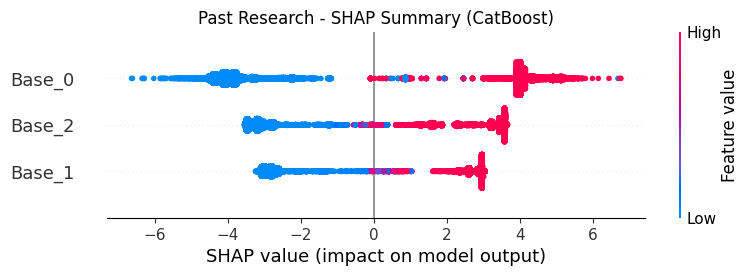


=== SHAP Feature Importance Summary ===
        Mean |SHAP|
Base_0     3.941126
Base_2     2.938873
Base_1     2.743907

=== Approach 1 ===
Accuracy: 0.9988, Precision: 0.9991, Recall: 0.9985, F1: 0.9988, ROC_AUC: 1.0000
FPR: 0.0009, FNR: 0.0015
Inference Time: 39.09 ms


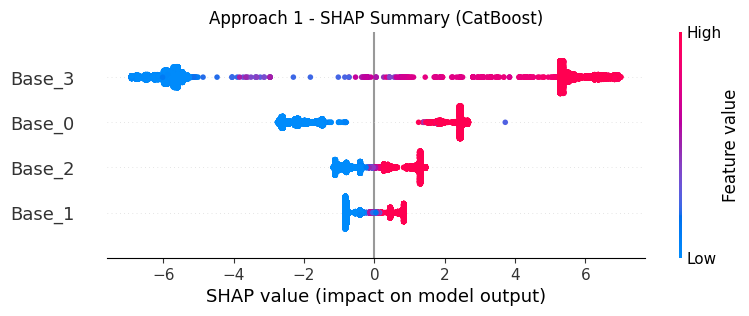


=== SHAP Feature Importance Summary ===
        Mean |SHAP|
Base_3     5.779583
Base_0     2.254868
Base_2     0.898741
Base_1     0.722433

=== Approach 2 ===
Accuracy: 0.9957, Precision: 0.9994, Recall: 0.9919, F1: 0.9956, ROC_AUC: 1.0000
FPR: 0.0006, FNR: 0.0081
Inference Time: 35.60 ms


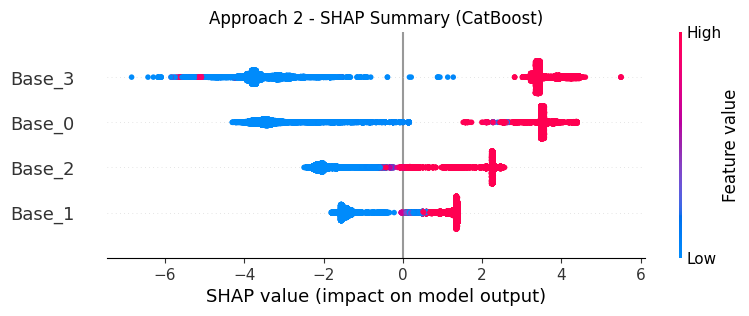


=== SHAP Feature Importance Summary ===
        Mean |SHAP|
Base_3     3.544388
Base_0     3.340472
Base_2     1.867254
Base_1     1.266212

=== Approach 3 ===
Accuracy: 0.9984, Precision: 0.9992, Recall: 0.9976, F1: 0.9984, ROC_AUC: 1.0000
FPR: 0.0008, FNR: 0.0024
Inference Time: 54.67 ms


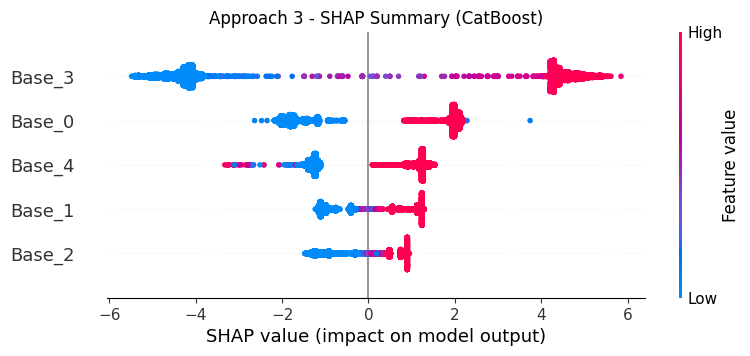


=== SHAP Feature Importance Summary ===
        Mean |SHAP|
Base_3     4.422030
Base_0     1.838764
Base_4     1.242567
Base_1     0.989951
Base_2     0.902356

=== Approach 4 ===
Accuracy: 0.9984, Precision: 0.9990, Recall: 0.9978, F1: 0.9984, ROC_AUC: 1.0000
FPR: 0.0010, FNR: 0.0022
Inference Time: 0.52 ms


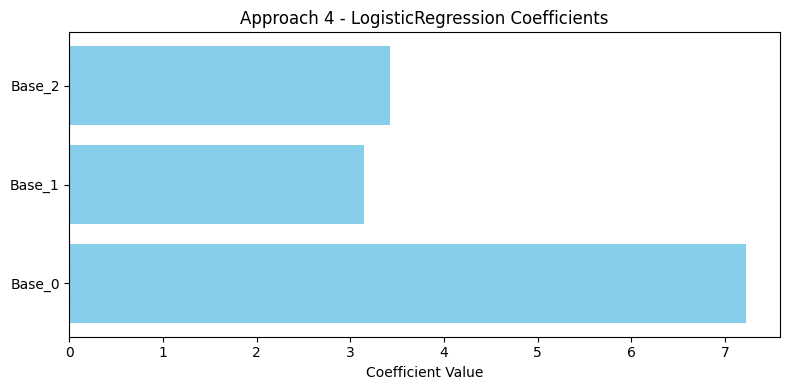

Logistic Regression Coefficients: [7.22666538 3.1461431  3.42631219]

=== Approach 5 ===
Accuracy: 0.9988, Precision: 0.9991, Recall: 0.9985, F1: 0.9988, ROC_AUC: 1.0000
FPR: 0.0009, FNR: 0.0015
Inference Time: 0.61 ms


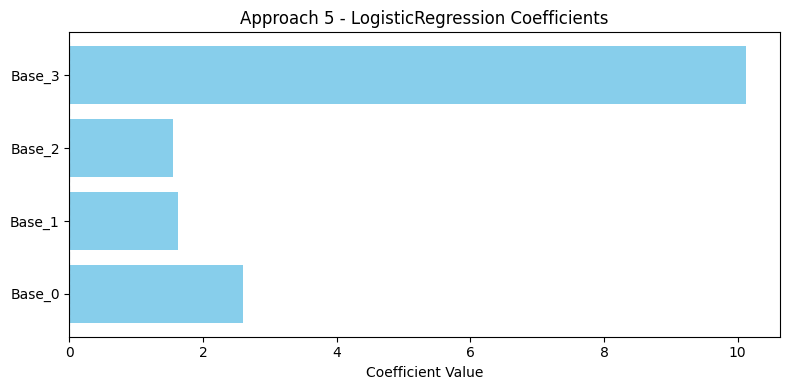

Logistic Regression Coefficients: [ 2.59434119  1.62878507  1.54370983 10.12882002]

=== Approach 6 ===
Accuracy: 0.9986, Precision: 0.9991, Recall: 0.9981, F1: 0.9986, ROC_AUC: 1.0000
FPR: 0.0009, FNR: 0.0019
Inference Time: 0.51 ms


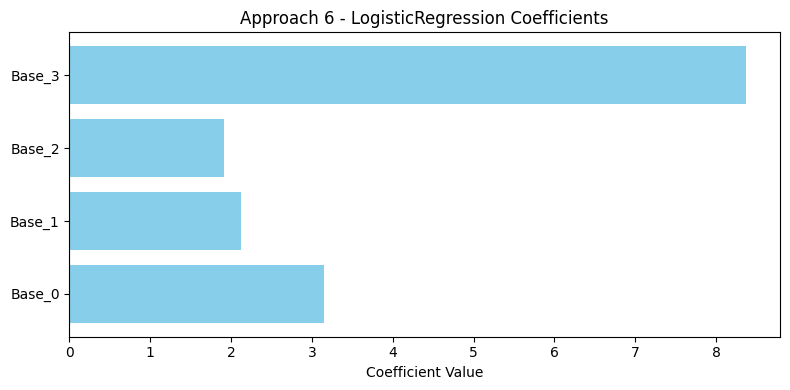

Logistic Regression Coefficients: [3.14414043 2.12007614 1.91346313 8.37328521]

=== Approach 7 ===
Accuracy: 0.9987, Precision: 0.9990, Recall: 0.9983, F1: 0.9987, ROC_AUC: 1.0000
FPR: 0.0010, FNR: 0.0017
Inference Time: 0.63 ms


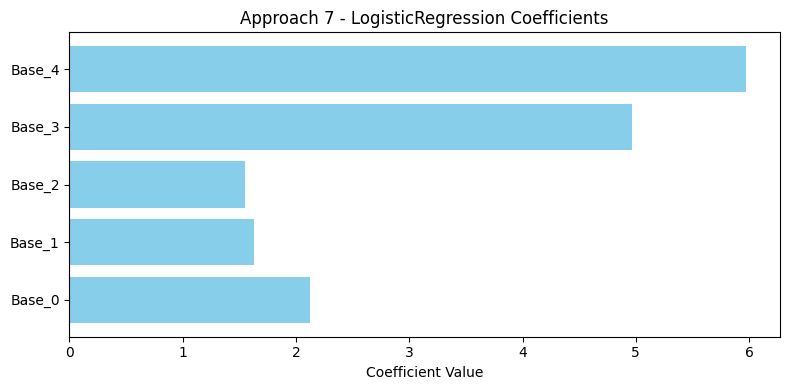

Logistic Regression Coefficients: [2.12506558 1.62904252 1.5534651  4.96770823 5.97460489]


In [24]:
import time
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Use latent features and their corresponding labels
X_train_latent = train_latent_features
X_test_latent = test_latent_features
y_train_latent = train_labels
y_test_latent = test_labels

print(y_train_latent.shape)

# Function to evaluate and explain models
def evaluate_and_explain(base_classifiers, meta_classifier, approach_name):
    for clf in base_classifiers:
        clf.fit(X_train_latent, y_train_latent)

    train_meta_features = np.column_stack([clf.predict_proba(X_train_latent)[:, 1] for clf in base_classifiers])
    test_meta_features = np.column_stack([clf.predict_proba(X_test_latent)[:, 1] for clf in base_classifiers])

    meta_classifier.fit(train_meta_features, y_train_latent)

    start_time = time.time()
    y_pred = meta_classifier.predict(test_meta_features)
    inference_time = time.time() - start_time

    acc = accuracy_score(y_test_latent, y_pred)
    prec = precision_score(y_test_latent, y_pred)
    rec = recall_score(y_test_latent, y_pred)
    f1 = f1_score(y_test_latent, y_pred)
    roc = roc_auc_score(y_test_latent, meta_classifier.predict_proba(test_meta_features)[:, 1])

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test_latent, y_pred).ravel()
    
    # Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)


    print(f"\n=== {approach_name} ===")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC_AUC: {roc:.4f}")
    print(f"FPR: {fpr:.4f}, FNR: {fnr:.4f}")
    print(f"Inference Time: {inference_time*1000:.2f} ms")

    feature_names = [f"Base_{i}" for i in range(len(base_classifiers))]

    if isinstance(meta_classifier, CatBoostClassifier):
        explainer = shap.TreeExplainer(meta_classifier)
        shap_values = explainer.shap_values(test_meta_features)
        shap.summary_plot(shap_values, test_meta_features, feature_names=feature_names, show=False)
        plt.title(f"{approach_name} - SHAP Summary (CatBoost)")
        plt.show()

        shap_df = pd.DataFrame(
            data=np.abs(shap_values).mean(axis=0),
            index=feature_names,
            columns=["Mean |SHAP|"]
        ).sort_values(by="Mean |SHAP|", ascending=False)

        print("\n=== SHAP Feature Importance Summary ===")
        print(shap_df)

    elif isinstance(meta_classifier, LogisticRegression):
        coefficients = meta_classifier.coef_[0]
        plt.figure(figsize=(8, 4))
        plt.barh(feature_names, coefficients, color="skyblue")
        plt.xlabel("Coefficient Value")
        plt.title(f"{approach_name} - LogisticRegression Coefficients")
        plt.axvline(0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()
        print(f"Logistic Regression Coefficients: {coefficients}")

# Define approaches
approaches = {
    "Past Research": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss")], CatBoostClassifier(verbose=0)),
    "Approach 1": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), RandomForestClassifier()], CatBoostClassifier(verbose=0)),
    "Approach 2": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), XGBClassifier(eval_metric='logloss')], CatBoostClassifier(verbose=0)),
    "Approach 3": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), RandomForestClassifier(), XGBClassifier(eval_metric='logloss')], CatBoostClassifier(verbose=0)),
    "Approach 4": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss")], LogisticRegression()),
    "Approach 5": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), RandomForestClassifier()], LogisticRegression()),
    "Approach 6": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), XGBClassifier(eval_metric='logloss')], LogisticRegression()),
    "Approach 7": ([SVC(probability=True), LogisticRegression(), SGDClassifier(loss="log_loss"), RandomForestClassifier(), XGBClassifier(eval_metric='logloss')], LogisticRegression()),
}

# Run all approaches
for name, (base_cls, meta_cls) in approaches.items():
    evaluate_and_explain(base_cls, meta_cls, name)
